# Matched Distribution and RFKO Tracking
(using Xtrack instead of PyBT)

- Start at resonance
- Add a quadrupole to move away from resonance
- Match a distribution
- Track and collapse quad over a few hundred turns
- You should see the ellipse transform into a triangular shape
- Then start RFKO

``dQ = Beta(at quad)*integrated_strength [m]*[m^-1]``


REFERNCE SIMPLE CASE - constantly on, simple noise
- [ ] No momentum spread
- [ ] Simpler functions
- [ ] Use RMS voltage = gaussian distribution, similar effect
- [ ] Look at sextupoles
- [ ] More particles?

- remove bumps

- [ ] Put septum in to remove particles - will remove "weirdness"

In [1]:
import xtrack as xt
import xpart as xp
import xobjects as xo

import pybt

import matplotlib.pyplot as plt

import json
from numpy import random
import random
import numpy as np

from cpymad.madx import Madx

import scipy as sp

from progressbar import progressbar

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Constants

In [2]:
REL_GAMMA = 25.598474067
REL_BETA = np.sqrt(1-REL_GAMMA**(-2))

exn = 1.5e-6
eyn = 1.5e-6
ex = exn/(REL_BETA*REL_GAMMA)
ey = eyn/(REL_BETA*REL_GAMMA)

p = 24 # beam momentum (GeV/c)
momentum = 24 # beam momentum (GeV/c)
Brho = 24*3.3356

PS_radius = 70.079
DPP_FACTOR = 1e-3

N_PART = int( 5e3 )

## QUAD COLLAPSE

TUNE_TARGET = 0.330
N_TURN = int( 5e2 )

DETUNE_QUAD_KNL1 = -0.04
CHROMATICITY_TARGET = -0.5
# DETUNE_QUAD_KNL1 = 0

## rifko

SEPTA = True
EXCITER_SAMPLING_FREQ = 1e6

CHIRP_START = .3
CHIRP_STOP = .35

CHIRP_INTERVAL = 0.001

N_TURN_CHIRP = int( 3e3 )

SEPTA_X_MM = -60

RFKO_STRENGTH = 1 

In [3]:
import os
DIR = f"prelim_results/rfko_quadcollapse_Q{round(TUNE_TARGET, 5)}_S{SEPTA_X_MM}_T{N_TURN_CHIRP}"
os.makedirs(DIR, exist_ok=True)
print(f"Directory: {DIR}")

Directory: prelim_results/rfko_quadcollapse_Q0.33_S-60_T3000


# Load PS at East Extraction

In [4]:
mad = Madx(stdout=True)

PS_REPO = "../../../../models/acc-models-ps/"

mad.call(PS_REPO+"ps_mu.seq")
mad.call(PS_REPO+"ps_ss.seq")
mad.call(PS_REPO+"scenarios/east/4_slow_extraction/ps_se_east.str")

mad.command.beam(
    particle="PROTON",
    pc = p,
    ex = ex,
    ey = ey
)
mad.input(f"BRHO      := BEAM->PC * 3.3356;")
mad.use(sequence="PS")
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
mad.input('savebeta, label=bumped23, place = PR.BPM23;')


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2023.03.31 16:12:14      +
  ++++++++++++++++++++++++++++++++++++++++++++
/**********************************************************************************

*

* Elements description and sequence file for each PS main unit (MU).

*

* 07/10/2020 - Alexander Huschauer

************************************************************************************/



/************************************************************************************

*

*         DEFINITION OF FOCUSING AND DEFOCUSING HALF-UNITS OF THE MU               

*

*************************************************************************************/



/************************************************************************************

*        							 F HALF-UNITS     					            

***********************

True

# Set PFWs, Cycle & Flatten

In [5]:
def tune_match(Qx,Qxp,Qy,Qyp,p,ex,ey):
    
    with open('tempfile', 'w') as f:
        madx = Madx(stdout=f,stderr=f)
        madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

    # Call latice files
    madx.call(PS_REPO+"ps_mu.seq")
    madx.call(PS_REPO+"ps_ss.seq")
    madx.call(PS_REPO+"scenarios/east/4_slow_extraction/ps_se_east.str")

    madx.command.beam(particle='PROTON',
                      pc=p,
                      ex=ex,
                      ey=ey)
    madx.input('BRHO      := BEAM->PC * 3.3356;')

    madx.use(sequence = "PS")
    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
    madx.input('savebeta, label=bumped23, place = PR.BPM23;')
    twiss_initial = madx.twiss().dframe()
    len_ps = twiss_initial.s[-1]

    ### Cycle sequence, changing starting point and adding markers at around the magnet 62
    madx.input('SEQEDIT, sequence=PS;')
    madx.input('FLATTEN;')
    madx.command.install(element = 'marker_ss62_end', class_='MARKER', at=0, from_='SS62$END')
    madx.command.install(element = 'marker_ss63_start', class_='MARKER', at=0, from_='SS63$START')
    madx.input('CYCLE, START=PR.BPM23;') # This will be the place to start the ejection sequence
    madx.input('FLATTEN;')
    madx.input('ENDEDIT;')
    madx.use(sequence='ps')
    madx.select(flag='makethin', class_='rbend', slice_=4)
    madx.select(flag='makethin', class_='quadrupole', slice_=4)
    madx.select(flag='makethin', class_='sbend', slice_=4)
    madx.select(flag='makethin', class_='sextupole', slice_=2)
    madx.makethin(sequence='ps')
    madx.use(sequence='ps')

    twiss_cycled = madx.twiss().dframe()
    
    madx.input('''
    ptc_twiss_macro(order, dp, slice_flag): macro = {
      ptc_create_universe;
      ptc_create_layout, time=false, model=2, exact=true, method=6, nst=3;
      IF (slice_flag == 1){
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,l,x,px,beta11,beta22,disp1,k1l;
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, slice_magnets=true;
      }
      ELSE{
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,x,px,beta11,alfa11,beta22,alfa22,disp1,disp2,mu1,mu2,energy,l,angle,K1L,K2L,K3L,HKICK,SLOT_ID;    
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, normal;
      }
      ptc_end;
    };

    ''')
    
    #/**********************************************************************************
    # *                        Matching using the PFW
    #***********************************************************************************/
    madx.input("Qx   := "+str(Qx)+"; !Horizontal Tune")
    madx.input("Qxp  := "+str(Qxp)+"; !Horizontal Chromaticity")

    madx.input("Qy   := "+str(Qy)+"; !Vertical Tune")
    madx.input("Qyp  := "+str(Qyp)+"; !Vertical Chromaticity")

    madx.input('''
    use, sequence=PS;
    match, use_macro;
            vary, name = k1prpfwf;
            vary, name = k1prpfwd;
            vary, name = k2prpfwf;
            vary, name = k2prpfwd;
            use_macro, name = ptc_twiss_macro(2,0,0);
            constraint, expr = table(ptc_twiss_summary,Q1)  = Qx;
            constraint, expr = table(ptc_twiss_summary,Q2)  = Qy;
            constraint, expr = table(ptc_twiss_summary,DQ1) = Qxp;
            constraint, expr = table(ptc_twiss_summary,DQ2) = Qyp;
    jacobian,calls=50000,bisec=3;
    ENDMATCH;
    ''')
    
    madx.use(sequence="PS")
    twiss_tune_matching = madx.twiss().dframe() # Needed to refresh the tune values
    madx.input('qx = table(SUMM, Q1);')
    madx.input('qy = table(SUMM, Q2);')
    madx.input('qxp = table(SUMM, DQ1);')
    madx.input('qyp = table(SUMM, DQ2);')
    
    tune_info_dict = {"Qx": madx.globals["qx"], "Qy": madx.globals["qy"], "Qxp": madx.globals["qxp"], "Qyp": madx.globals["qyp"]}
    pfw_dict = {"k1prpfwf": madx.globals["k1prpfwf"], "k1prpfwd": madx.globals["k1prpfwd"], "k2prpfwf": madx.globals["k2prpfwf"], "k2prpfwd": madx.globals["k2prpfwd"]}

    print (f"H-tune: {round(tune_info_dict['Qx'],3)}, H-Chroma: {round(tune_info_dict['Qxp'],3)}\nV-Tune: {round(tune_info_dict['Qy'],3)}, V-Chroma: {round(tune_info_dict['Qyp'],3)}")
    print (f"")
    print (f"PFW settings: \n  k1prpfwf: {round(pfw_dict['k1prpfwf'],6)}\n  k1prpfwd: {round(pfw_dict['k1prpfwd'],6)}\n  k2prpfwf: {round(pfw_dict['k2prpfwf'],6)}\n  k2prpfwd: {round(pfw_dict['k2prpfwd'],6)}")

    madx.quit()
    
    return pfw_dict, tune_info_dict

In [6]:
pfw_dict_on_resonance, tune_info_on_resonance = tune_match(Qx=TUNE_TARGET,Qxp=-1.239,Qy=0.3,Qyp=-0.242, p=p, ex=ex, ey=ey) # Chroma from measurements on 12.11.21 

H-tune: 6.33, H-Chroma: -1.239
V-Tune: 6.3, V-Chroma: -0.242

PFW settings: 
  k1prpfwf: 0.000232
  k1prpfwd: -0.000399
  k2prpfwf: 0.007812
  k2prpfwd: -0.018844


In [7]:
mad.input("k1prpfwf = "+str(pfw_dict_on_resonance["k1prpfwf"])+";")
mad.input("k1prpfwd = "+str(pfw_dict_on_resonance["k1prpfwd"])+";")
mad.input("k2prpfwf = "+str(pfw_dict_on_resonance["k2prpfwf"])+";")
mad.input("k2prpfwd = "+str(pfw_dict_on_resonance["k2prpfwd"])+";")
mad.use(sequence="PS")
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

##### INITIAL ##

twiss_initial = mad.twiss().dframe()
len_ps = twiss_initial.s[-1]

mad.input('SEQEDIT, sequence=PS;')
mad.input('FLATTEN;')
mad.command.install(element = 'marker_ss62_end', class_='MARKER', at=0, from_='SS62$END')
mad.command.install(element = 'marker_ss63_start', class_='MARKER', at=0, from_='SS63$START')
mad.command.install(element = 'marker_seh23', class_='MARKER', at=-0.4, from_='PE.SEH23')
mad.input('CYCLE, START=PR.BPM23;') # This will be the place to start the ejection sequence
mad.input('FLATTEN;')
mad.input('ENDEDIT;')
mad.use(sequence = "PS")

###### Rebecca's changes

# mad.input('kprqse = 0.13739;')
# mad.input('kprxse = 1.836;')
# mad.input('kprodn = -6.0;')

##### Initial Conditions

initial_conditions = (-0.07, (-0.00135 + -0.0015)/2)
# mad.input('kpebsw57 = 0.0;')
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
twiss_cycled_beta = mad.twiss(x=initial_conditions[0], px=initial_conditions[1], beta0="bumped23").dframe()
##### CYCLED ##
twiss_cycled = mad.twiss().dframe()



++++++ info: k1prpfwf redefined
++++++ info: k1prpfwd redefined
++++++ info: k2prpfwf redefined
++++++ info: k2prpfwd redefined
enter Twiss module
  
iteration:   1 error:   1.618914E-03 deltap:   0.000000E+00
orbit:   2.089515E-03  1.659873E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   2.917128E-05 deltap:   0.000000E+00
orbit:   2.077786E-03  1.665901E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   3 error:   1.119095E-09 deltap:   0.000000E+00
orbit:   2.077786E-03  1.665900E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
          628.3185                 -0      0.02576263648         6.23024101 

                q1                dq1            betxmax              dxmax 
       6.329678697     -0.02369831043        32.30808483        4.447511396 

             dxrms             xcomax             xcorms 

###
---

In [8]:
# Makethin
mad.use(sequence='ps')
mad.select(flag='makethin', class_='rbend', slice_=4)
mad.select(flag='makethin', class_='quadrupole', slice_=4)
mad.select(flag='makethin', class_='sbend', slice_=4)
mad.select(flag='makethin', class_='sextupole', slice_=2)
mad.makethin(sequence='ps')

# Convert to Xtrack
mad.use(sequence="PS")
line = xt.Line.from_madx_sequence(
    mad.sequence()
    )


makethin: slicing sequence : ps
Converting sequence "ps": 98%     


In [9]:
detuning_quad = xt.SimpleThinQuadrupole(
    knl = [0, DETUNE_QUAD_KNL1]
)
line.insert_element(
    element = detuning_quad,
    index = 0,
    name = "DETUNING_QUAD"
)

In [10]:
# Create monitors
ctx = xo.ContextCpu()

line.particle_ref = xp.Particles(
    mass0=xp.PROTON_MASS_EV,
    q0=1,
    p0c=p*sp.constants.c
)

In [11]:
tracker = line.build_tracker()
co_guess = line.build_particles(
    x = initial_conditions[0],
    px = initial_conditions[1],
)
tw = tracker.twiss(method='4d')

generating ./27c291f5a68649cc94092378d984a34a.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation'


In [12]:
FREV = 1/tw['T_rev']

In [13]:
x_in_sigmas, px_in_sigmas = xp.generate_2D_gaussian(N_PART)

# TODO: Explain why approximations, or show its the same without approximations

particles = line.build_particles(method='4d',
                    x_norm=x_in_sigmas, # sigmas
                    px_norm=px_in_sigmas, # sigmas
                    nemitt_x=exn, nemitt_y=eyn)

Text(0, 0.5, 'px [rad]')

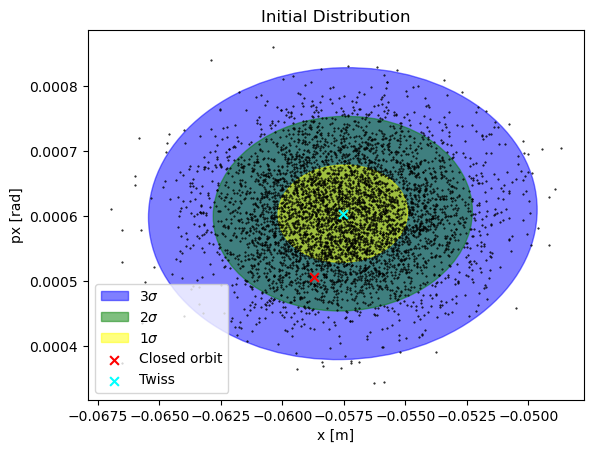

In [14]:
cov = np.cov([particles.x, particles.px])
cov_px = np.cov(particles.px)
w3, h3, r3 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=3)
w2, h2, r2 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=2)
w1, h1, r1 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=1)
co = tracker.find_closed_orbit()
tw = tracker.twiss(method='4d')
parms =  pybt.tools.particles.get_parms(particles.x, particles.px)
fig, ax = plt.subplots()
ax.plot(particles.x, particles.px, 'k.', markersize=1, zorder=3)
from matplotlib.patches import Ellipse, Rectangle
e3 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w3, height=h3, angle=r3, color='blue', alpha=.5, label='3$\sigma$')
e2 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w2, height=h2, angle=r2, color='green', alpha=.5, label='2$\sigma$')
e1 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w1, height=h1, angle=r1, color='yellow', alpha=.5, label='1$\sigma$')

# septa_region = Rectangle((septum.min_x, septum.min_y), septum.max_x-septum.min_x, septum.max_y-septum.min_y, color='red', alpha=.5, label='Septa')
# ax.add_artist(septa_region)

ax.add_artist(e3)
ax.add_artist(e2)
ax.add_artist(e1)

ax.scatter(co.x, co.px, color='red', marker='x', s=40, label='Closed orbit', zorder=4)
ax.scatter(tw.x[0], tw.px[0], color="xkcd:cyan", marker='x', s=40, label="Twiss", zorder=6)

ax.plot()
ax.legend()

ax.set_title("Initial Distribution")
ax.set_xlabel('x [m]')
ax.set_ylabel('px [rad]')


In [16]:
from signal_gen import generate_chirp
line.unfreeze()
chirp_time, chirp_signal = generate_chirp(
    sampling_freq = EXCITER_SAMPLING_FREQ,
    chirp_start_freq = CHIRP_START*FREV,
    chirp_stop_freq = CHIRP_STOP*FREV,
    chirp_rep_time = CHIRP_INTERVAL
)
rfko_exciter = xt.Exciter(
    _context = ctx,
    samples = chirp_signal,
    sampling_frequency = EXCITER_SAMPLING_FREQ,
    frev = FREV,
    start_turn = N_TURN,
    knl = [0.00001],
    duration = N_TURN_CHIRP/FREV
)
line.insert_element(
    element = rfko_exciter,
    name = 'EXCITER',
    index = 'pr.kfb97'
)

In [17]:
smh57_monitor = xt.ParticlesMonitor(
    _context = ctx,
    num_particles = N_PART,
    start_at_turn = 0,
    stop_at_turn = N_TURN+N_TURN_CHIRP
)
smh61_monitor = xt.ParticlesMonitor(
    _context = ctx,
    num_particles = N_PART,
    start_at_turn = 0,
    stop_at_turn = N_TURN+N_TURN_CHIRP
)
line.insert_element(
    element = smh57_monitor,
    name = 'SMH57_MONITOR',
    index = 'pe.smh57'
)
line.insert_element(
    element = smh61_monitor,
    name = 'SMH61_MONITOR',
    index = 'pe.smh61'
)

In [18]:
septum = xt.LimitRect(
    min_x = SEPTA_X_MM*0.001, # in meters
)
line.insert_element(
    element = septum,
    name = "SEPTUM",
    index = 'pe.smh57'
)

In [19]:
tracker = line.build_tracker()

generating ./c3ec8f3a25c549e4b5414b700724e898.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation'


In [20]:
# Perform MAD twiss
mad_twiss = mad.twiss()
mad_twiss_summ = mad_twiss.summary

# Track
tunes = []
strengths = []
losses = []
delta = line['DETUNING_QUAD'].knl[1]/N_TURN

print(f"Tracking for {N_TURN} for detuning, {N_TURN_CHIRP} for rfko")

for turn in range(N_TURN):
    # Detuning
    cur_strength = line['DETUNING_QUAD'].knl[1]
    line['DETUNING_QUAD'].knl[1] = cur_strength - delta
    tracker.track(particles)
    losses.append(particles._num_lost_particles)
    tune = tracker.twiss(method='4d')['qx']
    tunes.append(tune)
    strengths.append(line['DETUNING_QUAD'].knl[1])

enter Twiss module
  
iteration:   1 error:   5.710914E-02 deltap:   0.000000E+00
orbit:  -3.131495E-02 -1.031931E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   2.152970E-03 deltap:   0.000000E+00
orbit:  -3.380528E-02 -1.886046E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   3 error:   7.173865E-06 deltap:   0.000000E+00
orbit:  -3.380613E-02 -1.883829E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   4 error:   5.736347E-11 deltap:   0.000000E+00
orbit:  -3.380613E-02 -1.883829E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
          628.3185                 -0      0.02575697809        6.230925315 

                q1                dq1            betxmax              dxmax 
       6.329991589       -1.239487862        32.38813597        4.460995406 

             dxrms            

Need second attempt on closed orbit search


ClosedOrbitSearchError: 

: 

In [ ]:
tune_before = tw['qx']
print(f"Tune before detune: {tune_before}")
tw = tracker.twiss(method='4d')
tune_after = tw['qx']
print(f"Tune after detune: {tune_after}")

In [ ]:
RAD_TO_MRAD = 1000
M_TO_MM = 1000

# Plotting Detune

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots(figsize=(7, 7), tight_layout=False)

def animate(i):
    ax.clear()
    #ax.set_aspect("equal")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("px [rad]")
    ax.set_xlim(-0.075, 0.075)
    ax.set_ylim(-0.0015, 0.001)
    fig.suptitle(f"{i:>4}")
    # fig.suptitle(f"{i:>4} | k1l = {round(strengths[i], 4):>4} | Qx = {round(tunes[i], 3):>4}")
    ax.axvline(SEPTA_X_MM*0.001, color='red', linestyle='--', label='Septa')
    # septa_region = Rectangle((septum.min_x, septum.min_y), septum.max_x-septum.min_x, septum.max_y-septum.min_y, color='red', alpha=.5, label='Septa')
    # ax.add_artist(septa_region)
    try:
        ax.scatter(smh57_monitor.x.T[i], smh57_monitor.px.T[i], marker='.', s=2)
    except:
        print("fail at", i)
        pass
    return
ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=False, frames=N_TURN)
ani.save(f"{DIR}/quad_collapse.gif", writer=PillowWriter(fps=30))


In [ ]:
cov = np.cov([particles.x, particles.px])
cov_px = np.cov(particles.px)

w3, h3, r3 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=3)
w2, h2, r2 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=2)
w1, h1, r1 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=1)

co = tracker.find_closed_orbit()
tw = tracker.twiss(method='4d')
parms = pybt.tools.particles.get_parms(particles.x, particles.px)

fig, ax = plt.subplots()
ax.plot(particles.x, particles.px, 'k.', markersize=1, zorder=3)
e3 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w3, height=h3, angle=r3, color='blue', alpha=.5, label='3$\sigma$')
e2 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w2, height=h2, angle=r2, color='green', alpha=.5, label='2$\sigma$')
e1 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w1, height=h1, angle=r1, color='yellow', alpha=.5, label='1$\sigma$')

# septa_region = Rectangle((septum.min_x, septum.min_y), septum.max_x-septum.min_x, septum.max_y-septum.min_y, color='red', alpha=.5, label='Septa')
# ax.add_artist(septa_region)

ax.add_artist(e3)
ax.add_artist(e2)
ax.add_artist(e1)

ax.scatter(co.x, co.px, color='red', marker='x', s=40, label='Closed orbit', zorder=4)
ax.scatter(tw.x[0], tw.px[0], color="xkcd:cyan", marker='x', s=40, label="Twiss", zorder=6)

ax.plot()
ax.legend()

ax.set_title("Distribution after matching")
ax.set_xlabel('x [m]')
ax.set_ylabel('px [rad]')


# RFKO

In [ ]:
super_monitor = []
super_losses = []
mad.use(sequence="PS")
rfko_line = xt.Line.from_madx_sequence(
    mad.sequence()
)
for id, (x, px, y, py, zeta, delta) in enumerate(list(zip(particles.x, particles.px, particles.y, particles.py, particles.zeta, particles.delta))):
    part = xp.Particles(
        particle_ref = line.particle_ref,
        x = x,
        px = px,
    )
    np.random.seed(id)
    rfko_line_per_particle = rfko_line.filter_elements(exclude_types_starting_with="Exciter")
    print(rfko_line_per_particle[3704])
    rfko_line_per_particle.unfreeze()

    #random_noise = np.random.normal(0, RMS, N_TURN_CHIRP)
    rfko_exciter = xt.Exciter(
        _context = ctx,
        samples = chirp_signal,
        #samples = random_noise,
        sampling_frequency = EXCITER_SAMPLING_FREQ,
        frev = FREV,
        start_turn = 0,
        knl = [0.00001*RFKO_STRENGTH],
        duration = N_TURN_CHIRP/FREV
    )
    rfko_line_per_particle.insert_element(
        element = rfko_exciter,
        name = f'EXCITER_{id}',
        index = 'pr.kfb97'
    )
    smh57_monitor = xt.ParticlesMonitor(
        _context = ctx,
        num_particles = 1,
        start_at_turn = 0,
        stop_at_turn = N_TURN+N_TURN_CHIRP
    )
    rfko_line_per_particle.insert_element(
        element = smh57_monitor,
        name = 'SMH57_MONITOR',
        index = 'pe.smh57'
    )
    septum = xt.LimitRect(
        min_x = SEPTA_X_MM*0.001, # in meters
    )
    rfko_line_per_particle.insert_element(
        element = septum,
        name = "SEPTUM",
        index = 'pe.smh57'
    )
    rfko_tracker_per_particle = rfko_line_per_particle.build_tracker()
    rfko_tracker_per_particle.track(part, num_turns = N_TURN_CHIRP)
    super_monitor.append((smh57_monitor.x, smh57_monitor.px))
    super_losses.append(part.at_turn)
    print(f"Completed particle {id}/{N_PART}")
    del smh57_monitor
    del septum
    del rfko_exciter
    del rfko_line_per_particle

In [ ]:
with open(f"{DIR}/super_monitor.pkl", "wb") as f:
    np.save(f, np.array(super_monitor))
with open(f"{DIR}/super_losses.pkl", "wb") as f:
    np.save(f, np.array(super_losses))

In [ ]:
losses_ids = [i for i, x in enumerate(super_losses) if x[0] != 1000]
losses_turns = [x[0] for i, x in enumerate(super_losses) if x[0] != 1000]
lost_positions = [(lost_turn, (super_monitor[id][0][0][lost_turn], super_monitor[id][1][0][lost_turn])) for lost_turn, id in list(zip(losses_turns, losses_ids))]

# frequency of losses_turns
from collections import Counter
losses_counter = Counter(losses_turns)
sorted(losses_counter.items())
losses_culm = [0]
for i in range(N_TURN_CHIRP):
    losses_culm.append(losses_culm[-1] + losses_counter[i])

    

In [ ]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

cm = plt.get_cmap("viridis")

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
fig.tight_layout(pad=5.0)
for i in range(N_PART):
#for i in range(10):
    sctr = ax.scatter(M_TO_MM*super_monitor[i][0][0][:1000], RAD_TO_MRAD*super_monitor[i][1][0][:1000], cmap='viridis', c=range(0, 1000), s=4)

ax.set_xlim(-100, 30)
ax.set_ylim(-1.75, 1.3)
ax.set_xlabel('x [mm]')
ax.set_ylabel('px [mrad]')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sctr, cax=cax, orientation='vertical')
cax.set_ylabel("Turn")
ax.axvline(SEPTA_X_MM, color='red', linestyle='--', label='Septum')
ax.set_title(f"Phase space evolution of random noise RFKO\nQx = {tunes[-1]}, {N_TURN_CHIRP} turns, {N_PART} particles")

for turn, position in lost_positions:
    ax.scatter(M_TO_MM*position[0], RAD_TO_MRAD*position[1], color='red', s=10)

fig.savefig(f"{DIR}/evolution.png", dpi=300)

In [ ]:
super_monitor_x = np.array([super_monitor[i][0][0] for i in range(N_PART)])
super_monitor_px = np.array([super_monitor[i][1][0] for i in range(N_PART)])

In [ ]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(7, 7), tight_layout=False
                        , gridspec_kw={'height_ratios': [4, 1]}
                       )

cm = plt.get_cmap("viridis")

def animate(i):
    ax.clear()
    try:
        ax.scatter(M_TO_MM*super_monitor_x.T[int(i*3)], RAD_TO_MRAD*super_monitor_px.T[int(i*3)], marker='.', s=2, color=cm(1/6), label=f"{(i*3):>4}")
        ax.scatter(M_TO_MM*super_monitor_x.T[int(i*3)+1], RAD_TO_MRAD*super_monitor_px.T[int(i*3)+1], marker='.', s=2, color=cm(3/6), label=f"{(i*3):>4}+1")
        ax.scatter(M_TO_MM*super_monitor_x.T[int(i*3)+2], RAD_TO_MRAD*super_monitor_px.T[int(i*3)+2], marker='.', s=2, color=cm(5/6), label=f"{(i*3):>4}+2")
        for lst_turn, lst_position in lost_positions:
            if lst_turn <= i*3 and lst_turn > (i*3)-3:
                ax.scatter(M_TO_MM*lst_position[0], RAD_TO_MRAD*lst_position[1], color='red', s=10, zorder=10)
            elif lst_turn <= (i*3)-3 and lst_turn > (i*3)-6:
                ax.scatter(M_TO_MM*lst_position[0], RAD_TO_MRAD*lst_position[1], color='red', s=9, alpha=.9, zorder=9)
            elif lst_turn <= (i*3)-6 and lst_turn > (i*3)-9:
                ax.scatter(M_TO_MM*lst_position[0], RAD_TO_MRAD*lst_position[1], color='red', s=7, alpha=.8, zorder=8)
            elif lst_turn <= i*3:
                ax.scatter(M_TO_MM*lst_position[0], RAD_TO_MRAD*lst_position[1], color='xkcd:salmon', s=5, alpha=.5, zorder=1)
        ax2.plot(losses_culm[:int(i*3)], color='black', label='Lost particles')
        
    except:
        print("fail at", int(i*3))
        pass
    else:
        print("success at", int(i*3))
    finally:
        ax.set_xlabel("x [mm]")
        ax.set_ylabel("px [mrad]")
        ax.set_xlim(-100, 30)
        ax.set_ylim(-1.75, 1.75)
        fig.suptitle(f"Turn: {(i*3):>4}")
        ax.axvline(SEPTA_X_MM, color='red', linestyle='--', label='Septum')
        leg = ax.legend(loc='upper left')
        leg.legendHandles[0]._sizes = [40]
        leg.legendHandles[1]._sizes = [40]
        leg.legendHandles[2]._sizes = [40]
        ax2.set_xlim(0, N_TURN_CHIRP)
        ax2.set_ylim(0, max(losses_culm))
        ax2.set_xlabel("Turn")
        ax2.set_ylabel("Extracted (cts.)")
    return
ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=False, frames=int(N_TURN_CHIRP/3))
ani.save(f"{DIR}/rfko_3_turns.gif", writer=PillowWriter(fps=30))


# Saving with Memmap or Parquet

DTypes = float64

In [ ]:
# Particles
particles.to_pandas().to_parquet(f"{DIR}/particles.parquet")
# Losses
loss_np = np.array(losses)
loss_mmap = np.memmap('losses.npy', mode='w+', dtype='float64', shape=loss_np.shape)
loss_mmap[:] = loss_np[:]
# Sequence
mad.save(sequence = 'ps', file = f"{DIR}/sequence.seq")

In [ ]:
constant_dict = {
    "distribution":
        {
            "rel_gamma": REL_GAMMA,
            "rel_beta": REL_BETA,
            "exn": exn,
            "eyn": eyn,
            "ex": ex,
            "ey": ey,
            "p": p,
            "momentum": momentum,
            "Brho": Brho,
            "DPP_FACTOR": DPP_FACTOR,
            "N_PART": N_PART,
        },
    "quad_collapse":
        {
            "TUNE_TARGET": TUNE_TARGET,
            "N_TURN": N_TURN,
            "DETUNE_QUAD_KNL1": DETUNE_QUAD_KNL1,
        },
    "rfko":
        {
            "SEPTA": SEPTA,
            "EXCITER_SAMPLING_FREQ": EXCITER_SAMPLING_FREQ,
            "FREV": FREV,
            "CHIRP_START": CHIRP_START,
            "CHIRP_STOP": CHIRP_STOP,
            "CHIRP_INTERVAL": CHIRP_INTERVAL,
            "N_TURN_CHIRP": N_TURN_CHIRP,
            "SEPTA_X_MM": SEPTA_X_MM,
        },
}
# save to file
with open(f"{DIR}/constants.json", "w") as f:
    json.dump(constant_dict, f, indent=4)